***Install Dependencies***



In [1]:
!pip install -q transformers accelerate datasets scikit-learn \
matplotlib seaborn arabic-reshaper python-bidi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 43.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's de

***Imports***

In [ ]:
import re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

#hardware check - should be cude/GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#QARiB
model_name = "ahmedabdelali/bert-base-qarib"
print(f"Model Selected: {model_name}")


2025-12-11 10:11:41.637185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765447901.813510      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765447901.883887      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda
Model Selected: ahmedabdelali/bert-base-qarib


***Cleaning Function***

In [ ]:
print("Cleaning Function")

def advanced_clean(text):
    text = str(text)
    #remove Tashkeel (Diacritics)
    text = re.sub(r'[\u064B-\u065F]', '', text)
    #remove Tatweel (Elongation)
    text = re.sub(r'ـ', '', text)
    #normalize Alef letter
    text = re.sub(r'[إأآ]', 'ا', text)
    #normalize Taa Marbuta letter
    text = re.sub(r'ة', 'ه', text)
    #normalize Yaa letter
    text = re.sub(r'ى', 'ي', text)
    #remove Numbers
    text = re.sub(r'\d+', '', text)
    #remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    #remove extra Whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

Cleaning Function


***Load Dataset***

In [4]:
print("⬇ Loading dataset...")
dataset = load_dataset("omkarthawakar/FannOrFlop")

df = dataset["train"].to_pandas()[["poem_verses", "era"]].dropna()

print("Applying Advanced Cleaning...")
print("Before:", df["poem_verses"].iloc[0][:80])
df["poem_verses"] = df["poem_verses"].apply(advanced_clean)
print("After :", df["poem_verses"].iloc[0][:80])

df.head()


⬇ Loading dataset...


README.md: 0.00B [00:00, ?B/s]

dataset.json:   0%|          | 0.00/99.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6984 [00:00<?, ? examples/s]

Applying Advanced Cleaning...
Before: 1

حَيّـاكُمُ اللَـهُ أَحيـوا العِلمَ وَالأَدَبا

إِن تَنشُروا العِلمَ يَنشُر في
After : حياكم اللةاحيوا العلم والادبا ان تنشروا العلم ينشر فيكم العربا ولا حياة لكم الا 


,poem_verses,era
0,حياكم اللةاحيوا العلم والادبا ان تنشروا العلم ...,العصر الحديث
1,غاب الاديب اديب مصر واختفى فلتبكةالاقلام او تت...,العصر الحديث
2,عثمان انك قد اتيت موفقا شروى سميك جامع التنزيل...,العصر الحديث
3,ان عضيك يا اخىبالملام لا يؤدىلمثل هذا الخصام ا...,العصر الحديث
4,من واجد منقر المنام طريد دهر جائر الاحكام مشتت...,العصر الحديث


***Split & Encode Labels***



In [ ]:
#encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["era"])

label2id = {label: idx for idx, label in enumerate(le.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

print("Classes:", list(le.classes_))

#stratified split
train_df, val_df = train_test_split(
    df,
    ttest_size = 0.2, #this goes to val_df
    stratify = df["label"], #ensure class distribution is preserved
    random_state = 42 #stability so every time we run code we get same split
)

print(f"Train size: {len(train_df)}")
print(f"Val size  : {len(val_df)}")

train_df["label"].value_counts()


Classes: ['الدولة الايوبية', 'الدولة الفاطمية', 'الدولة المملوكية', 'الشعراء المخضرمون', 'العصر الأموي', 'العصر الإسلامي', 'العصر الحديث', 'العصر العباسي', 'العصر العثماني', 'المغرب والأندلس', 'عصر بين الدولتين', 'قبل الإسلام']
Train size: 5587
Val size  : 1397


label
7     1874
6      560
4      454
9      357
0      330
1      327
2      326
3      307
11     299
8      261
10     257
5      235
Name: count, dtype: int64

***Balance Data (Upsampling)***

In [ ]:
print("Balancing training data...")
max_size = train_df["label"].value_counts().max() #counting samples in each class
balanced_parts = []

for label_id in train_df["label"].unique(): #looping over each class
    subset = train_df[train_df["label"] == label_id]
    upsampled = resample(
        subset,
        replace = True,
        n_samples = max_size,
        random_state = 42,
    )
    balanced_parts.append(upsampled)

train_df_balanced = pd.concat(balanced_parts)
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced train size:", len(train_df_balanced))
train_df_balanced["label"].value_counts()


Balancing training data...
Balanced train size: 22488


label
0     1874
5     1874
9     1874
10    1874
2     1874
4     1874
8     1874
3     1874
6     1874
11    1874
7     1874
1     1874
Name: count, dtype: int64

***Tokenization***

In [ ]:
print(f"Loading tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)


MAX_LEN = 256   
print("Using max length:", MAX_LEN)

def preprocess_function(examples):
    return tokenizer(
        examples["poem_verses"],
        truncation = True,
        max_length = MAX_LEN,
    )

print("Tokenizing data...")
train_ds = Dataset.from_pandas(train_df_balanced)
val_ds   = Dataset.from_pandas(val_df)

#apply tokenization
train_ds = train_ds.map(preprocess_function, batched=True)
val_ds   = val_ds.map(preprocess_function, batched=True)

#remove/ clean columns not needed - era already encoded as label :)
cols_to_remove_train = [c for c in ["era", "__index_level_0__"] if c in train_ds.column_names]
cols_to_remove_val   = [c for c in ["era", "__index_level_0__"] if c in val_ds.column_names]

train_ds = train_ds.remove_columns(cols_to_remove_train)
val_ds   = val_ds.remove_columns(cols_to_remove_val)

train_ds


Loading tokenizer: ahmedabdelali/bert-base-qarib


config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Using max length: 256
Tokenizing data...


Map:   0%|          | 0/22488 [00:00<?, ? examples/s]

Map:   0%|          | 0/1397 [00:00<?, ? examples/s]

Dataset({
    features: ['poem_verses', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 22488
})

***Initialize Model***

In [ ]:
print("Initializing Model...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(le.classes_),
    id2label=id2label,
    label2id=label2id,
).to(device)

print("Model ready.")

Initializing Model...


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ahmedabdelali/bert-base-qarib and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Model ready.


***Training Setup***

In [ ]:
#computing the metrics: Accuracy & F1 Score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
    }

training_args = TrainingArguments(
    output_dir="./qarib_out",          
    overwrite_output_dir=True,         
    
    #evaluation strategy - each happens per epoch
    eval_strategy = "epoch",
    logging_strategy = "epoch",
    save_strategy = "no",
    load_best_model_at_end = False,

    #optimization tuning
    learning_rate = 2e-5, #common learning rate for BERT 
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2, 

    #scheduler & epochs
    num_train_epochs = 10, #10 passes over training data
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.1, #10% of training steps increse lineraly to lr ,, stable at early point

    report_to = "none",
)

trainer = Trainer(
    model = model,#QARiB
    args = training_args,#all hyperparameters and strategies written above :)
    train_dataset = train_ds,#tokanized dataset
    eval_dataset = val_ds,#tokanized dataset
    tokenizer = tokenizer,
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer),#pad each batch to max length dynamically
    compute_metrics = compute_metrics,#compute metrics after each eval
)


/tmp/ipykernel_47/2381054600.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


***Train Model***

In [10]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.957600,1.672062,0.415175,0.405795
2,0.618000,1.662503,0.508232,0.516334
3,0.120000,2.057217,0.508232,0.522348
4,0.034600,2.334078,0.579814,0.566746
5,0.016400,2.795467,0.536865,0.547588
6,0.004900,2.740503,0.583393,0.573468
7,0.001000,2.855717,0.585540,0.578165
8,0.000700,2.897588,0.584109,0.583625
9,0.000600,2.921601,0.574803,0.575070
10,0.000600,2.920807,0.577666,0.577475


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=3520, training_loss=0.2754320788747546, metrics={'train_runtime': 6123.7591, 'train_samples_per_second': 36.723, 'train_steps_per_second': 0.575, 'total_flos': 2.95868633112576e+16, 'train_loss': 0.2754320788747546, 'epoch': 10.0})

***Evaluate and Visualize***


Final Report :


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


                   precision    recall  f1-score   support

  الدولة الايوبية      0.382     0.470     0.422        83
  الدولة الفاطمية      0.636     0.341     0.444        82
 الدولة المملوكية      0.614     0.622     0.618        82
الشعراء المخضرمون      0.425     0.447     0.436        76
     العصر الأموي      0.685     0.553     0.612       114
   العصر الإسلامي      0.313     0.356     0.333        59
     العصر الحديث      0.787     0.714     0.749       140
    العصر العباسي      0.625     0.714     0.667       468
   العصر العثماني      0.565     0.538     0.551        65
  المغرب والأندلس      0.477     0.472     0.475        89
 عصر بين الدولتين      0.875     0.438     0.583        64
      قبل الإسلام      0.372     0.427     0.398        75

         accuracy                          0.578      1397
        macro avg      0.563     0.508     0.524      1397
     weighted avg      0.594     0.578     0.577      1397



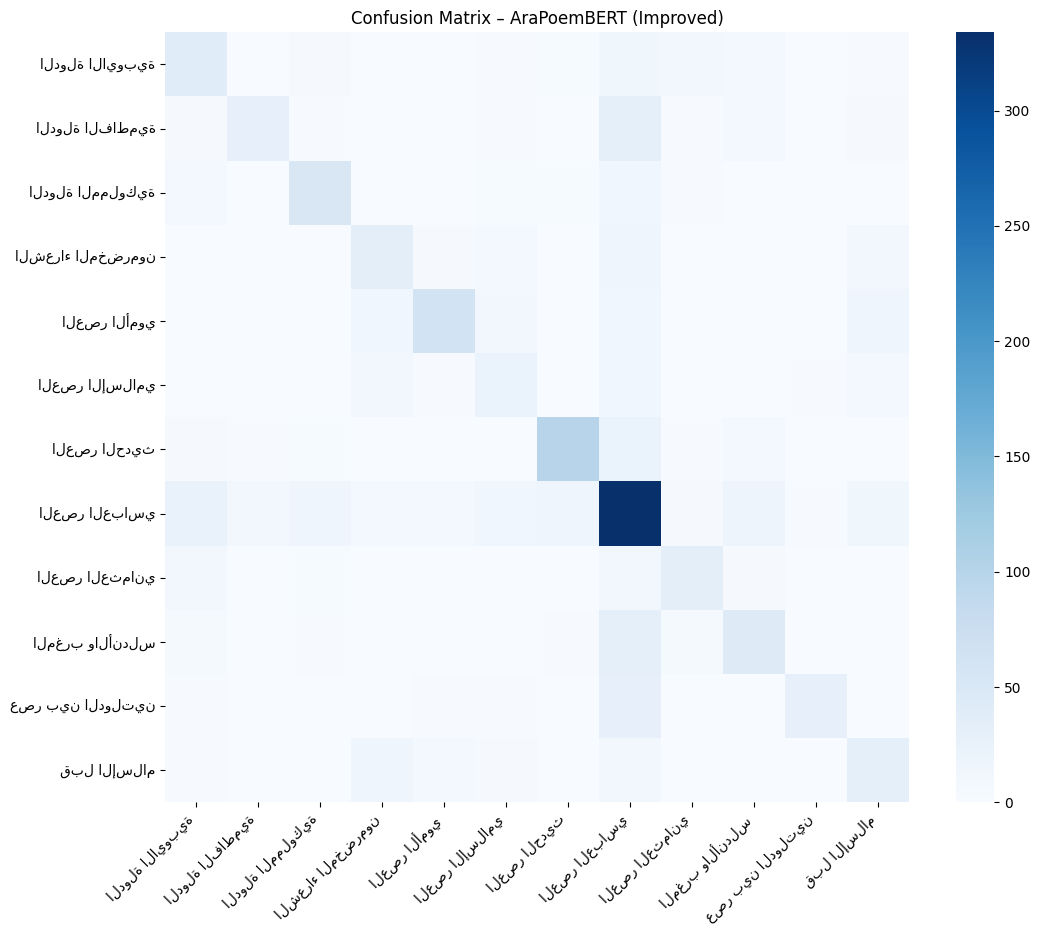

In [ ]:
print("\nFinal Report :")
pred_output = trainer.predict(val_ds)
#prediction is in shape of (samples, 12) and converted to argmax(axis=1)
#which means selecting class with highest score
y_pred = np.argmax(pred_output.predictions, axis = 1)
y_true = pred_output.label_ids

#printing text report
print(classification_report(y_true, y_pred, target_names = le.classes_, digits = 3))

#visualizing Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot = False,
    cmap = "Blues",
    xticklabels = le.classes_,
    yticklabels = le.classes_,
)
plt.title("Confusion Matrix – AraPoemBERT (Improved)")
plt.xticks(rotation = 45, ha = "right")
plt.yticks(rotation = 0)
plt.show()
